In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn import *
import pandas as pd
import csv

In [3]:
# load training data labels
train_labels_info = pd.read_csv('train_labels.csv', header=0)  
categories = list(np.unique(train_labels_info['label']))

# endocing categories to numbers
num2cat = dict(zip(range(len(categories)), categories))
cat2num =dict(zip(categories,range(len(categories))))
print(cat2num)
print(num2cat)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


In [4]:
def write_csv_kaggle_sub(fname, ID, Y):
    # fname = file name
    # Y is a list/array with class entries
    # ID is the image ID
    tmp = [['ID', 'label']]
    # add ID numbers for each Y
    for (i,y) in enumerate(Y):
        tmp2 = [ID[i], num2cat[y]]
        tmp.append(tmp2)
    # write CSV file
    with open(fname, 'w',newline='') as f:
        writer = csv.writer(f)
        writer.writerows(tmp)

In [5]:
train_feat_root = './res50_features/train_feat/'
test_feat_root = './res50_features/test_feat/'

train_feats = []
test_feats = []

train_labels = []
test_img_id = []

# load train features
for feat in os.listdir(train_feat_root):
    img_id = int(feat.split('_')[0])
    train_feats.append(np.load(os.path.join(train_feat_root, feat)))

    label = train_labels_info['label'][img_id]
    train_labels.append(cat2num[label])

# load test features and corresponding ID
for feat in os.listdir(test_feat_root):
    img_id = int(feat.split('_')[0])
    test_img_id.append(img_id)
    test_feats.append(np.load(os.path.join(test_feat_root, feat)))

print(len(train_feats))
print(len(test_feats))

10500
2200


In [ ]:
# Splitting training set and validation set for offline evaluation
trainX, valX, trainY, valY = model_selection.train_test_split(train_feats, train_labels, train_size=0.75, test_size=0.25, random_state=123)
print(len(trainX))
print(len(valX))

# Investigation on classifiers

In [8]:
# paramgrid = {'C': logspace(-1,5,20), 'gamma': logspace(-4,3,20) }
# svmclf = model_selection.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=5, n_jobs=-1, verbose=True)
svmclf = svm.SVC(kernel='linear')
svmclf.fit(trainX, trainY)
predY_svm = svmclf.predict(valX)
acc_svm = metrics.accuracy_score(valY, predY_svm)
print("linear svm validation accuracy =", acc_svm)

linear svm validation accuracy = 0.9135238095238095


In [11]:
svmclf = svm.SVC(kernel='rbf')
svmclf.fit(trainX, trainY)
predY_svm = svmclf.predict(valX)
acc_svm = metrics.accuracy_score(valY, predY_svm)
print("rbf svm validation accuracy =", acc_svm)

rbf svm validation accuracy = 0.932952380952381


In [12]:
# Generate submission files
predY = svmclf.predict(test_feats)
write_csv_kaggle_sub('naive_baseline.csv',  test_img_id, predY)

# Dimensionality Reduction

In [14]:
pca = decomposition.PCA(n_components=1024)
trainW = pca.fit_transform(trainX)  # fit the training set
valW  = pca.transform(valX)  # use the pca model to transform the test set
svmclf  = svm.SVC(kernel='linear')
svmclf.fit(trainW, trainY)
predY_svm = svmclf.predict(valW)
acc_svm = metrics.accuracy_score(valY, predY_svm)
print("PCA svm validation accuracy =", acc_svm)

PCA svm validation accuracy = 0.908952380952381


In [17]:
pca = decomposition.KernelPCA(n_components=1024,kernel='rbf')
trainW = pca.fit_transform(trainX)  # fit the training set
valW  = pca.transform(valX)  # use the pca model to transform the test set
svmclf  =svm.SVC(kernel='linear')
svmclf.fit(trainW, trainY)
predY_svm = svmclf.predict(valW)
acc_svm = metrics.accuracy_score(valY, predY_svm)
print("Kernel PCA svm validation accuracy =", acc_svm)

Kernel PCA svm validation accuracy = 0.9314285714285714


1 : 0.6175238095238095
2 : 0.8106666666666666
4 : 0.864
8 : 0.8986666666666666
16 : 0.9100952380952381
32 : 0.9192380952380952
64 : 0.9215238095238095
128 : 0.9241904761904762
256 : 0.928
512 : 0.9287619047619048
1024 : 0.9314285714285714


Text(0, 0.5, 'accuracy')

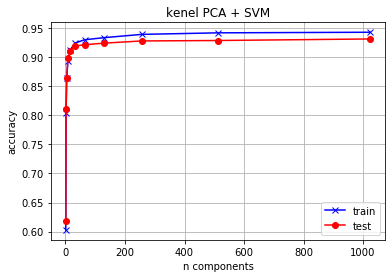

In [19]:
ns=[1,2,4,8,16,32,64,128,256,512,1024]

# params = {'C': logspace(-6,3,15)}
trainaccpca = []
testaccpca = []
for n in ns:
    pca = decomposition.KernelPCA(n_components=n, kernel='rbf')
    trainW = pca.fit_transform(trainX)  # fit the training set
    testW  = pca.transform(valX)  # use the pca model to transform the test set
    clf  =svm.SVC(kernel='linear')
    clf.fit(trainW, trainY)
    
    # predict from the model
    predYtrain = clf.predict(trainW)
    predYtest  = clf.predict(testW)

    # calculate accuracy
    acc      = metrics.accuracy_score(trainY, predYtrain)
    trainaccpca.append(acc)

    # calculate accuracy
    acc      = metrics.accuracy_score(valY, predYtest)
    testaccpca.append(acc)
    print(n, ":",acc)

plt.plot(ns, trainaccpca, 'bx-', label='train')
plt.plot(ns, testaccpca, 'ro-', label='test')
plt.title("kenel PCA + SVM")
plt.legend(loc=0)
plt.grid(True); plt.xlabel('n components'); plt.ylabel('accuracy')   